<a href="https://colab.research.google.com/github/anandt555/BigData-Practice/blob/main/Team_225_MAB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Group ID: 225**
### Group Members Name with Student ID:
1. Mahalaxmi (2024aa05508)
2. Vankudre Pravin Subhash (2024aa05510)
3. Gowtham G (2024aa05864)
4. Jadhav Aditya Goverdhan (2024aa05521)


# Scenario

A pharmaceutical company is conducting clinical trials to evaluate the effectiveness of three antiretroviral drug combinations for treating HIV-positive patients. Due to the ethical and cost constraints of clinical trials, it is critical to identify the most effective treatment regimen using the least number of patients. Each treatment (or “arm”) can lead to different outcomes depending on patient responses. The effectiveness of each treatment is evaluated using a reward function derived from the improvement in patients’ immune system markers and survival status.



# Problem Definition

You are provided with a clinical dataset where each record corresponds to a patient, including the treatment they received and the resulting health outcomes. Your task is to simulate a clinical trial environment using various MAB strategies to sequentially recommend treatments and observe outcomes. The objective is to maximize the overall success rate across trials by identifying and favouring the most effective treatment.



# Dataset

You will be provided a dataset containing the following fields:

* ***Age (age)***: Patient's age in years at baseline.
* ***Weight (wtkg)***: Continuous feature representing weight in kilograms at baseline.
* ***Gender (gender)***: Binary indicator of gender (0 = Female, 1 = Male).
* ***CD4 Counts (cd40, cd420)***: Integer values representing CD4 counts at baseline and 20+/-5 weeks.
* ***Treatment Indicator (trt)***: Categorical feature indicating the type of treatment received (0 = ZDV only, 1 = ZDV + ddI, 2 = ZDV + Zal, 3 = ddI only).
* ***Censoring Indicator (label)***: Binary indicator (1 = failure, 0 = censoring) denoting patient status.


***Link for accessing dataset:***
https://drive.google.com/file/d/1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-/view?usp=sharing


# Environment Setup

***Arms (Actions):*** The treatment types (trt)
* Arm 0: ZDV only
* Arm 1: ZDV + ddI
* Arm 2: ZDV + Zal
* Arm 3: ddI only


**Reward Function:**

Reward `r` is defined as:

`r = 1, if (label == 0) and (cd420 > cd40)`

`r = 0, otherwise`


  
This reward represents a successful treatment outcome as an increase in CD4 count and survival.

**Assumptions:**

*Number of Iterations:* Run the simulation for at least 1000 trials (iterations), with the option to extend the number of trials depending on the convergence behavior or observed reward trends. In each iteration, simulate one patient trial using one of the bandit policies.


# Requirements and Deliverables:
Implement the Multi-Arm Bandit Problem for the given above scenario for all the below mentioned policy methods.

### Initialize constants

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import math

In [ ]:
# Constants
iterations = 1000


# Load Dataset (0.5M)

In [ ]:
# Code for Dataset loading and print dataset statistics
import pandas as pd

# Direct download link (replace with actual file ID if different)
file_url = 'https://drive.google.com/uc?export=download&id=1LYfIrJ4VEEGeyOsSt_qoLk7FaAv5Jfx-'

# Load dataset
df = pd.read_csv(file_url)
print("Dataset shape:", df.shape)
print(df.head())


Dataset shape: (2139, 7)
   age     wtkg  gender  cd40  cd420  trt  label
0   48  89.8128       0   422    477    2      0
1   61  49.4424       0   162    218    3      1
2   45  88.4520       1   326    274    3      0
3   47  85.2768       1   287    394    3      0
4   43  66.6792       1   504    353    0      0


In [ ]:
# Define a function to compute the binary reward for each patient
def get_reward(row):
    # Reward is 1 if the patient survived (label == 0)
    # and their CD4 count improved after treatment (cd420 > cd40)
    return 1 if row['label'] == 0 and row['cd420'] > row['cd40'] else 0

# Apply the reward function to each row of the dataframe
# and create a new column 'reward' to store the result
df['reward'] = df.apply(get_reward, axis=1)


# Design a Clinical Trial Environment (0.5M)

In [ ]:
# Code for environment setup along with reward function
class ClinicalTrialEnvironment:
    def __init__(self, df):
        self.df = df  # Patient dataset
        self.n_arms = df['trt'].nunique()  # Number of unique treatment arms

    def get_random_patient(self):
        return self.df.sample(1).iloc[0]  # Return a random patient

    def simulate(self, action, patient):
        # Return reward if selected treatment matches assigned treatment
        return patient['reward'] if patient['trt'] == action else 0



# Using Random Policy (0.5M)
Implement a random policy for treatment selection and print each iteration. (Mandatory)

In [ ]:
def run_random_policy(env, iterations):
    rewards = []  # Stores reward values for each iteration
    for i in range(iterations):
        patient = env.get_random_patient()                      # Randomly selects a patient
        action = np.random.randint(env.n_arms)                  # Randomly selects a treatment arm
        reward = env.simulate(action, patient)                  # Simulates the result of that action
        print(f"Iteration {i+1}: Selected Arm = {action}, Patient ID = {patient.name}, Reward = {reward}")
        rewards.append(reward)                                  # Records the reward
    return rewards


# Using Greedy Policy (1M)
Implement the Greedy policy that always selects the treatment with the highest average reward and print each iteration. (Mandatory)

In [ ]:
def run_greedy_policy(env, iterations):
    rewards = []
    arm_rewards = np.zeros(env.n_arms)  # Cumulative rewards for each arm
    arm_counts = np.zeros(env.n_arms)   # Number of times each arm is selected

    for i in range(iterations):
        patient = env.get_random_patient()  # Sample a random patient

        # Compute average reward per arm; avoid division by zero
        avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts!=0)

        # Select best arm so far, ensure each arm is tried once
        action = np.argmax(avg_rewards) if i >= env.n_arms else i

        reward = env.simulate(action, patient)  # Simulate treatment outcome
        print(f"Iteration {i+1}: Selected Arm = {action}, Patient ID = {patient.name}, Reward = {reward}")

        arm_counts[action] += 1  # Update arm count
        arm_rewards[action] += reward  # Update total reward
        rewards.append(reward)  # Log reward

    return rewards


# Using Epsilon-Greedy Policy (1.5M)
Implement the ε-Greedy policy with ε = 0.1, 0.2, 0.5. Report iteration-wise selections and rewards. Determine which ε yields the best result. (Mandatory)

In [ ]:
def run_epsilon_greedy(env, iterations, epsilon):
    rewards = []
    arm_rewards = np.zeros(env.n_arms)  # Cumulative rewards per arm
    arm_counts = np.zeros(env.n_arms)   # Count of selections per arm

    for i in range(iterations):
        patient = env.get_random_patient()  # Sample a random patient

        # ε-greedy strategy: explore with prob ε, exploit otherwise
        if np.random.rand() < epsilon:
            action = np.random.randint(env.n_arms)  # Exploration
        else:
            avg_rewards = np.divide(arm_rewards, arm_counts, out=np.zeros_like(arm_rewards), where=arm_counts!=0)
            action = np.argmax(avg_rewards) if i >= env.n_arms else i  # Exploitation

        reward = env.simulate(action, patient)  # Simulate treatment outcome
        print(f"Iteration {i+1}: Selected Arm = {action}, Patient ID = {patient.name}, Reward = {reward}")

        arm_counts[action] += 1  # Update arm selection count
        arm_rewards[action] += reward  # Update total reward for selected arm
        rewards.append(reward)  # Store reward

    return rewards


# Using UCB (1M)
Implement the UCB algorithm for treatment selection and print each  iteration. (Mandatory)

In [ ]:
def run_ucb(env, iterations):
    rewards = []
    arm_rewards = np.zeros(env.n_arms)  # Cumulative rewards per arm
    arm_counts = np.zeros(env.n_arms)   # Count of selections per arm

    for i in range(iterations):
        patient = env.get_random_patient()  # Sample a random patient

        if i < env.n_arms:
            action = i  # Ensure each arm is selected at least once
        else:
            avg_rewards = arm_rewards / arm_counts  # Mean reward per arm
            ucb_values = avg_rewards + np.sqrt(2 * np.log(i + 1) / arm_counts)  # UCB formula
            action = np.argmax(ucb_values)  # Select arm with highest UCB

        reward = env.simulate(action, patient)  # Simulate treatment outcome
        print(f"Iteration {i+1}: Selected Arm = {action}, Patient ID = {patient.name}, Reward = {reward}")

        arm_counts[action] += 1  # Update arm count
        arm_rewards[action] += reward  # Update reward sum
        rewards.append(reward)  # Log reward

    return rewards


# Plot the cumulative rewards for all policies on a single graph to compare their performance. (0.5M)

Streaming output truncated to the last 5000 lines.
Iteration 5: Selected Arm = 0, Patient ID = 1472, Reward = 0
Iteration 6: Selected Arm = 0, Patient ID = 2129, Reward = 0.0
Iteration 7: Selected Arm = 0, Patient ID = 2108, Reward = 0
Iteration 8: Selected Arm = 0, Patient ID = 1645, Reward = 0.0
Iteration 9: Selected Arm = 0, Patient ID = 1267, Reward = 0
Iteration 10: Selected Arm = 0, Patient ID = 1793, Reward = 0
Iteration 11: Selected Arm = 0, Patient ID = 832, Reward = 0
Iteration 12: Selected Arm = 0, Patient ID = 609, Reward = 0.0
Iteration 13: Selected Arm = 0, Patient ID = 1141, Reward = 0
Iteration 14: Selected Arm = 0, Patient ID = 2091, Reward = 0
Iteration 15: Selected Arm = 0, Patient ID = 257, Reward = 0.0
Iteration 16: Selected Arm = 0, Patient ID = 1954, Reward = 0
Iteration 17: Selected Arm = 0, Patient ID = 996, Reward = 0
Iteration 18: Selected Arm = 0, Patient ID = 2060, Reward = 0
Iteration 19: Selected Arm = 0, Patient ID = 1238, Reward = 0
Iteration 20: Select

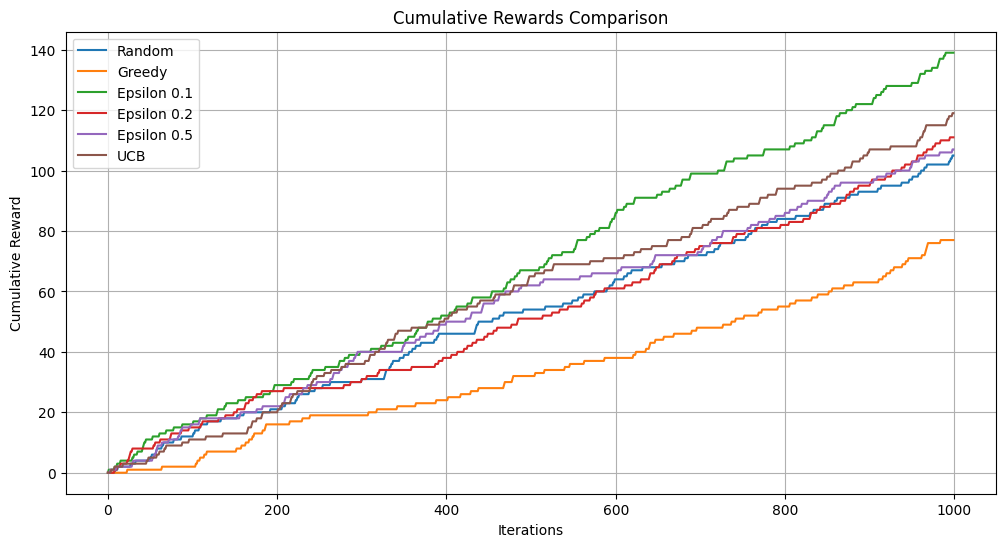

In [ ]:
# Initialize the environment with patient data
env = ClinicalTrialEnvironment(df)

# Run different policies
print("Random policy")
random_rewards = run_random_policy(env, iterations) # random policy
print("Greedy policy")
greedy_rewards = run_greedy_policy(env, iterations) # greedy policy
print("ε-Greedy policy with ε = 0.1")
epsilon_01 = run_epsilon_greedy(env, iterations, 0.1) # ε-Greedy policy with ε = 0.1
print("ε-Greedy policy with ε = 0.2")
epsilon_02 = run_epsilon_greedy(env, iterations, 0.2) # ε-Greedy policy with ε = 0.2
print("ε-Greedy policy with ε = 0.3")
epsilon_05 = run_epsilon_greedy(env, iterations, 0.5) # ε-Greedy policy with ε = 0.5
print("UCB policy")
ucb_rewards = run_ucb(env, iterations) # UCB policy

# Plot cumulative rewards for all policies
def plot_cumulative_rewards(rewards_list, labels):
    plt.figure(figsize=(12, 6))
    for rewards, label in zip(rewards_list, labels):
        cumulative = np.cumsum(rewards)  # Calculate cumulative reward over time
        plt.plot(cumulative, label=label)
    plt.xlabel("Iterations")
    plt.ylabel("Cumulative Reward")
    plt.title("Cumulative Rewards Comparison")
    plt.legend()
    plt.grid(True)
    plt.show()

# Visualize performance of all policies
plot_cumulative_rewards(
    [random_rewards, greedy_rewards, epsilon_01, epsilon_02, epsilon_05, ucb_rewards],
    ['Random', 'Greedy', 'Epsilon 0.1', 'Epsilon 0.2', 'Epsilon 0.5', 'UCB']
)


# Conclusion (0.5M)

write a conclusion (approximately 250 words) summarizing which treatment policy was most effective. Discuss the balance between exploration and exploitation in your simulations.

**Conclusion:**

In this simulation of a clinical trial environment using the Multi-Armed Bandit approach, we tested several treatment selection strategies: Random, Greedy, Epsilon-Greedy (with different epsilon values), and UCB.

The **Epsilon-Greedy strategy** with **ε = 0.1** clearly outperformed all other approaches. This method achieved the highest cumulative reward by intelligently balancing exploration (trying out different treatments) and exploitation (selecting the best-known treatment). Its performance demonstrates the value of maintaining a small degree of randomness to discover high-reward options that may not be initially evident.

The **Greedy strategy**, which always selects the treatment with the highest historical average reward, performed reasonably well in the early stages but suffered due to its lack of exploration. It often became trapped in suboptimal choices. Random selection, on the other hand, failed to capitalize on any known good treatments, resulting in relatively poor performance.

The **UCB strategy** showed competitive behavior, particularly in mid-to-late iterations, and outperformed purely greedy and higher-epsilon Epsilon-Greedy variants. However, it still fell short of the performance seen with ε = 0.1.

In conclusion, the experiment highlights that strategies incorporating both exploration and exploitation, especially **Epsilon-Greedy with ε = 0.1**, are most effective in adaptive clinical settings. These approaches offer a practical solution to ethical and cost constraints by maximizing patient outcomes with fewer trials.
